#**Creating word2vec models**

In [1]:
!pip install -q gensim
!npm install -q -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
/tools/node/lib
└─┬ localtunnel@1.9.0 
  ├─┬ axios@0.17.1 
  │ ├─┬ follow-redirects@1.4.1 
  │ │ └── debug@3.1.0 
  │ └── is-buffer@1.1.6 
  ├─┬ debug@2.6.8 
  │ └── ms@2.0.0 
  ├── openurl@1.1.1 
  └─┬ yargs@6.6.0 
    ├── camelcase@3.0.0 
    ├─┬ cliui@3.2.0 
    │ ├─┬ strip-ansi@3.0.1 
    │ │ └── ansi-regex@2.1.1 
    │ └── wrap-ansi@2.1.0 
    ├── decamelize@1.2.0 
    ├── get-caller-file@1.0.2 
    ├─┬ os-locale@1.4.0 
    │ └─┬ lcid@1.0.0 
    │   └── invert-kv@1.0.0 
    ├─┬ read-pkg-up@1.0.1 
    │ ├─┬ find-up@1.1.2 
    │ │ ├── path-exists@2.1.0 
    │ │ └─┬ pinkie-promise@2.0.1 
    │ │   └── pinkie@2.0.4 
    │ └─┬ read-pkg@1.1.0 
    │   ├─┬ load-json-file@1.1.0 
    │   │ ├── graceful-fs@4.1.11 
    │   │ ├─┬ parse-json@2.2.0 
    │   │ │ └─┬ error-ex@1.3.1 
    │   │ │   └── is-arrayish@0.2.1 
    │   │ ├── pify@2.3.0 
    │   │ └─┬ strip-bom@2.0.0 
    │   │   └── is-utf8@0.2.1 
    │   ├─┬ normal

In [0]:
from __future__ import absolute_import, division, print_function


import multiprocessing
import os , json , requests
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [3]:
"""**Download NLTK tokenizer models (only the first time)**"""

nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
"""## Prepare Corpus

**Load books from files**
"""
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return map(lambda x:x.lower(),words)
  

In [5]:
filepath = 'http://www.gutenberg.org/files/33224/33224-0.txt'

corpus_raw = requests.get(filepath).text

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

raw_sentences = tokenizer.tokenize(corpus_raw)


#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))
        
        
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 425,633 tokens


In [6]:
#@title Default title text
corpus_raw[0:1000]

u'\ufeffThe Project Gutenberg EBook of Principles of Geology, by Charles Lyell\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.  You may copy it, give it away or\r\nre-use it under the terms of the Project Gutenberg License included\r\nwith this eBook or online at www.gutenberg.org\r\n\r\n\r\nTitle: Principles of Geology\r\n       or, The Modern Changes of the Earth and its Inhabitants\r\n       Considered as Illustrative of Geology\r\n\r\nAuthor: Charles Lyell\r\n\r\nRelease Date: July 22, 2010 [EBook #33224]\r\n\r\nLanguage: English\r\n\r\nCharacter set encoding: UTF-8\r\n\r\n*** START OF THIS PROJECT GUTENBERG EBOOK PRINCIPLES OF GEOLOGY ***\r\n\r\n\r\n\r\n\r\nProduced by Julia Miller, Turgut Dincer and the Online\r\nDistributed Proofreading Team at http://www.pgdp.net (This\r\nfile was produced from images generously made available\r\nby The Internet Archive/American Libraries.)\r\n\r\n\r\n\r\n\r\n\r\n +------------------

In [43]:
raw_sentences[0]

u'\ufeffThe Project Gutenberg EBook of Principles of Geology, by Charles Lyell\r\n\r\nThis eBook is for the use of anyone anywhere at no cost and with\r\nalmost no restrictions whatsoever.'

In [44]:
sentences[0]

[u'the',
 u'project',
 u'gutenberg',
 u'ebook',
 u'of',
 u'principles',
 u'of',
 u'geology',
 u'by',
 u'charles',
 u'lyell',
 u'this',
 u'ebook',
 u'is',
 u'for',
 u'the',
 u'use',
 u'of',
 u'anyone',
 u'anywhere',
 u'at',
 u'no',
 u'cost',
 u'and',
 u'with',
 u'almost',
 u'no',
 u'restrictions',
 u'whatsoever']

In [0]:
 """## Train Word2Vec"""
# Dimensionality of the resulting word vectors more dimensions, more computationally expensive to train but also more accurate
# more dimensions = more generalized

num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.

#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1


model2vec = w2v.Word2Vec(
            sg=1,
            seed=seed,
            workers=num_workers,
            size=num_features,
            min_count=min_word_count,
            window=context_size,
            sample=downsampling
        )
        
model2vec.build_vocab(sentences)
    

In [45]:
model2vec['sun']

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.24759261,  0.08399712, -0.02325697,  0.07235891,  0.03294636,
        0.23051861,  0.09745344, -0.18141656,  0.05684838,  0.16672216,
        0.0014436 , -0.06824683,  0.03634454,  0.17633584,  0.13244139,
        0.02932553,  0.22731024, -0.08304039, -0.08212496,  0.04622704,
       -0.09803821,  0.05208622,  0.3044551 , -0.21992882, -0.03952049,
        0.10124406, -0.04561843,  0.10354353,  0.05342993,  0.21933857,
       -0.11442254, -0.1520098 ,  0.29882225,  0.23699975,  0.19032907,
       -0.03479375,  0.05801526, -0.06170395, -0.23831545, -0.08932548,
        0.00517454, -0.01614446,  0.0818908 , -0.20511207,  0.18375678,
       -0.118029  , -0.01080932,  0.16006151,  0.11602695,  0.0791762 ,
        0.07276348,  0.14120515,  0.07538143, -0.09593097, -0.04632708,
       -0.10853272, -0.07436209, -0.13376378, -0.12217211,  0.056185  ,
       -0.19883993,  0.02619065,  0.20009376, -0.08401223, -0.02618953,
        0.0014068 ,  0.06506111, -0.05393472,  0.07712927,  0.01

In [0]:
"""**Start training, this might take a minute or two...**"""

model2vec.train(sentences ,total_examples=model2vec.corpus_count , epochs=10)

"""**Save to file, can be useful later**"""

if not os.path.exists(os.path.join("trained",'sample')):
    os.makedirs(os.path.join("trained",'sample'))

model2vec.save(os.path.join("trained",'sample', ".w2v"))



# **Making Word cluster plot**

In [0]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

all_word_vectors_matrix = model2vec.wv.vectors




all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model2vec.wv.vocab[word].index])
            for word in model2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [22]:
points.head(10)

,word,x,y
0,writings,18.037668,-43.886780
1,grossier,8.635079,1.985248
2,yellow,-32.106766,34.795181
3,four,29.540060,53.059269
4,woods,3.016516,21.532457
5,preface,13.175848,-34.633808
6,woody,13.505670,39.037464
7,increase,-39.282745,-25.281944
8,granting,-24.096724,-23.974689
9,electricity,-43.038403,-21.750805


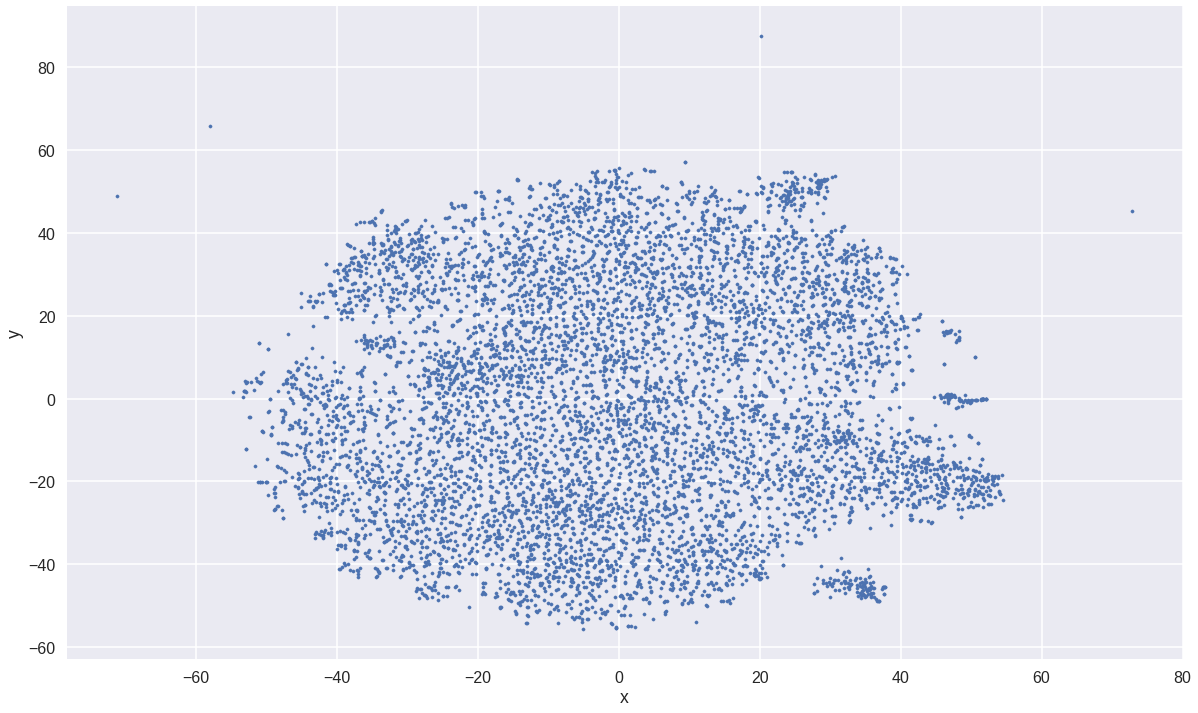

In [23]:
sns.set_context("poster")
    
ax = points.plot.scatter("x", "y", s=10, figsize=(20, 12))


fig = ax.get_figure()
# fig.savefig(os.path.join("trained",'sample'+".png"))

In [0]:
def plot_region(x_bounds, y_bounds):
        slice = points[
            (x_bounds[0] <= points.x) &
            (points.x <= x_bounds[1]) & 
            (y_bounds[0] <= points.y) &
            (points.y <= y_bounds[1])
        ]
        
        ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
        for i, point in slice.iterrows():
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

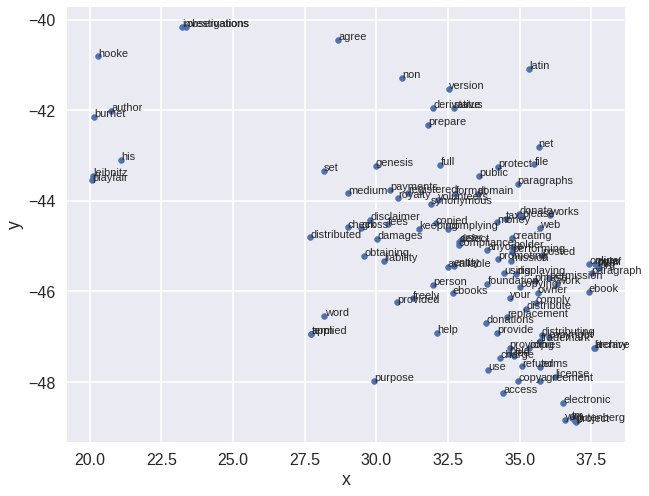

In [26]:
plot_region(x_bounds=(20.0, 40.0), y_bounds=(-60.0, -40.0))

In [47]:
model2vec.most_similar("earth")

model2vec.most_similar(positive=['moon','earth'], negative=['orbit'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[(u'crust', 0.6913913488388062),
 (u'globe', 0.6678174138069153),
 (u'inequalities', 0.6158996820449829),
 (u'orbit', 0.6076242327690125),
 (u'planet', 0.607271134853363),
 (u'laboring', 0.6042432188987732),
 (u'sun', 0.5897826552391052),
 (u'reduce', 0.587811291217804),
 (u'moon', 0.5690791606903076),
 (u'eccentricity', 0.5670342445373535)]

# **Creating Tensorboard vizualization**

In [7]:
vocab_list = points.word.values.tolist()
embeddings = all_word_vectors_matrix


embedding_var = tf.Variable(all_word_vectors_matrix, dtype='float32', name='embedding')
projector_config = projector.ProjectorConfig()


embedding = projector_config.embeddings.add()
embedding.tensor_name = embedding_var.name

LOG_DIR='./'
metadata_file = os.path.join("sample.tsv")



with open(os.path.join(LOG_DIR, metadata_file), 'wt') as metadata:
    metadata.writelines("%s\n" % w.encode('utf-8') for w in vocab_list)

embedding.metadata_path =  os.path.join(os.getcwd(), metadata_file)

# Use the same LOG_DIR where you stored your checkpoint.
summary_writer = tf.summary.FileWriter(LOG_DIR)

# The next line writes a projector_config.pbtxt in the LOG_DIR. TensorBoard will
# read this file during startup.
projector.visualize_embeddings(summary_writer, projector_config)

saver = tf.train.Saver([embedding_var])

with tf.Session() as sess:
    # Initialize the model
    sess.run(tf.global_variables_initializer())

    saver.save(sess, os.path.join(LOG_DIR, metadata_file+'.ckpt'))

NameError: ignored

In [30]:
LOG_DIR = './'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')
! cat url.txt


your url is: https://good-newt-65.localtunnel.me
/tools/node/lib/node_modules/localtunnel/bin/client:65
        throw err;
        ^

Error: connection refused: localtunnel.me:33429 (check your firewall settings)
    at Socket.<anonymous> (/tools/node/lib/node_modules/localtunnel/lib/TunnelCluster.js:47:32)
    at emitOne (events.js:96:13)
    at Socket.emit (events.js:188:7)
    at emitErrorNT (net.js:1278:8)
    at _combinedTickCallback (internal/process/next_tick.js:74:11)
    at process._tickCallback (internal/process/next_tick.js:98:9)
your url is: https://wonderful-warthog-2.localtunnel.me
